# <font color="#CA3532">Explicabilidad de redes neuronales</font>

Ejemplo detallado con el problema Iris.

In [2]:
import tensorflow as tf

import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

## <font color="#CA3532">Carga de los datos del problema Iris</font>

In [5]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
iris = load_iris()

La variable ``iris`` es un diccionario con los siguientes elementos:

- ``data``: array de numpy con los datos del problema (no incluye la clase). Cada fila es un ejemplo (150), cada columna es un atributo (4).
- ``target``: array de numpy con las clases de los 150 ejemplos, cada clase es un número entre 0 y 2.
- ``target_names``: array de numpy con los nombres de las 3 clases.
- ``DESCR``: string con una descripción del problema.
- ``feature_names``: lista con los nombres de los 4 atributos.
- ``filename``: nombre del fichero que contiene los datos.

In [7]:
iris = load_iris()
x = iris.data
t = iris.target

np.random.seed(42)
p = np.random.permutation(len(x))
x = x[p, :]
t = t[p][:, None]

# Particion entrenamiento-test:
x_train, x_test, t_train, t_test = train_test_split(x, t, test_size=0.33, random_state=42)

# NO ME OLVIDO DE NORMALIZAR PARA EXPLICAR
medias = x_train.mean(axis=0, keepdims=True)
stds = x_train.std(axis=0, keepdims=True)
x_train = (x_train-medias)/stds
x_test = (x_test-medias)/stds

### <font color="#CA3532">Construcción del modelo</font>

In [8]:
def build_model(input_dim, hidden_size, output_dim, optimizer="Adam", l1reg=0.0):
    input_layer = tf.keras.layers.Input(shape=(input_dim,))
    dense_layer = tf.keras.layers.Dense(hidden_size, activation="relu",
                                        kernel_regularizer=tf.keras.regularizers.l1(l1reg))(input_layer)
    output_layer = tf.keras.layers.Dense(output_dim, activation="softmax")(dense_layer)
    
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer)
    return model

In [46]:
input_dim = x_train.shape[1]
output_dim = len(np.unique(t_train))

hidden_size = 20
l1reg = 0.1
learning_rate = 1e-2

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model = build_model(input_dim, hidden_size, output_dim, optimizer=optimizer, l1reg=l1reg)
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense_14 (Dense)            (None, 20)                100       
                                                                 
 dense_15 (Dense)            (None, 3)                 63        
                                                                 
Total params: 163 (652.00 Byte)
Trainable params: 163 (652.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


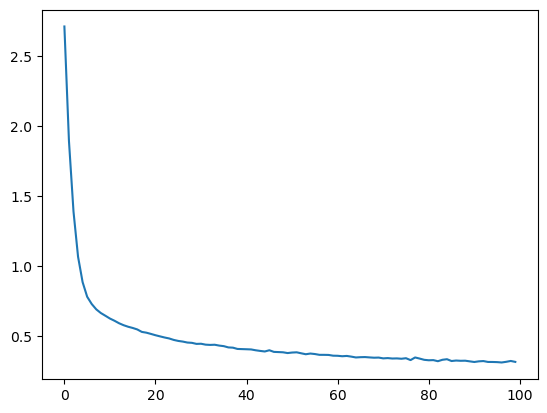

In [47]:
h = model.fit(x_train, t_train, batch_size=10, epochs=100, verbose=0)
plt.plot(h.history["loss"])
plt.show()

In [48]:
pred = model.predict(x_test)
np.mean(np.argmax(pred, axis=1) == t_test[:, 0])

2/2 [==============================] - 0s 2ms/step


0.98

Representemos una red neuronal completa con Graphviz.

In [49]:
from graphviz import Digraph

def draw_network(inputs, hidden, outputs, color_input=None):
    # Crear un grafo dirigido
    dot = Digraph(comment='Ejemplo de Grafo Dirigido')
    dot.attr(rankdir='LR')

    # Agregar nodos
    for i in range(inputs):
        if color_input == i+1:
            dot.node('x'+str(i+1), 'x'+str(i+1), color="red")
            dot.node("i"+str(i+1), "", shape="point", style='invis')
            dot.edge("i"+str(i+1), "x"+str(i+1), color="red")
        else:
            dot.node('x'+str(i+1), 'x'+str(i+1))
            dot.node("i"+str(i+1), "", shape="point", style='invis')
            dot.edge("i"+str(i+1), "x"+str(i+1))
        
    for i in range(hidden):
        dot.node('h'+str(i+1), 'h'+str(i+1))
        
    for i in range(outputs):
        dot.node('y'+str(i+1), 'y'+str(i+1))
        dot.node("o"+str(i+1), "", shape="point", style='invis')
        dot.edge("y"+str(i+1), "o"+str(i+1))

    for i in range(inputs):
        for j in range(hidden):
            for k in range(outputs):
                dot.edge('h'+str(j+1), 'y'+str(k+1))
            if color_input == i+1:
                dot.edge("x"+str(i+1), "h"+str(j+1), color="red")
            else:
                dot.edge("x"+str(i+1), "h"+str(j+1))

    return dot

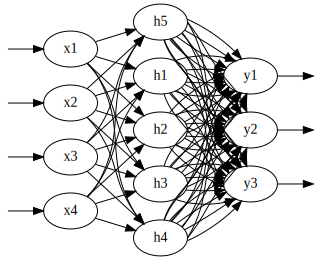

In [50]:
draw_network(4, 5, 3)

La salida de este modelo está definida como:

$$\mathbf{z}^h = \mathbf{x} \mathbf{W}^h + \mathbf{b}^h$$

$$\mathbf{h} = f(\mathbf{z}^h)$$

$$\mathbf{z}^y = \mathbf{h} \mathbf{W}^y + \mathbf{b}^y$$

$$y_i = softmax_i(\mathbf{z}^y) = \frac{e^{z_i^y}}{\sum_j e^{z_j^y}}$$

donde $\mathbf{x}$ es el vector de atributos de entrada, $\mathbf{W}^h$ y $\mathbf{W}^y$ son las matrices de pesos, y $\mathbf{b}^h$ y $\mathbf{b}^y$ son los vectores de *bias* de cada capa. Así, el vector $\mathbf{y}$ representa la probabilidad asignada del modelo a cada una de las clases.

### Hagamos selección de atributos según los pesos

Intentemos hacer selección de atributos según los pesos de la red...

Esperad. Ahora no tenemos una matriz de pesos $\mathbf{W}$, sino que tenemos **dos matrices** $\mathbf{W}^h$ y $\mathbf{W}^y$. ¿Qué hacemos?

Vamos a pensar... Una entrada está conectada a muchas neuronas en la capa oculta.

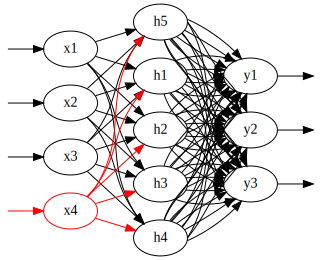

In [51]:
draw_network(4, 5, 3, color_input=4)

¿Y si consideramos la suma de pesos como **cómo influye la entrada en total a todas las neuronas de la capa oculta**?

$$R_{xi} = \sum_j |W^h_{ij}|$$

Esto se conoce como **relevancia global de los atributos de entrada según los pesos en valor absoluto**. Nos ayuda a entender cómo cada entrada influye en general en el modelo.

In [52]:
def global_relevance(model):
    w = model.layers[1].weights[0]
    R = np.abs(w).sum(axis=1)
    return R

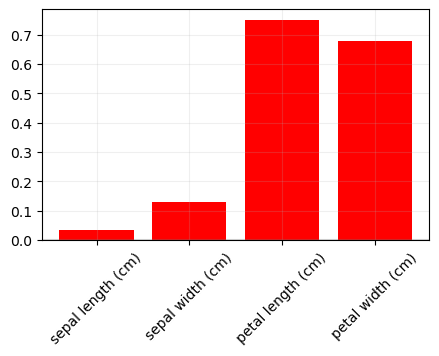

In [53]:
R = global_relevance(model)

plt.figure(figsize=(5, 3))
plt.bar(range(x_train.shape[1]), R, color="red")
plt.xticks(range(x_train.shape[1]), iris.feature_names, rotation=45)
plt.grid(alpha=0.2)
plt.axhline(0.0, color="gray", alpha=0.3)
plt.show()

### Hagamos explicabilidad de la red según la derivada

Recordad que para la explicabilidad de cualquier modelo basado en redes neuronales, una opción es calcularla a partir de sus gradientes (**Gradient x Input**). Si quieres explicar qué tiene que pasar en la entrada para que la predicción del modelo se acerque al valor real:

$$R_{\mathbf{x}} = - |\mathbf{x}| \cdot \nabla_\mathbf{x}L(\mathbf{y}, \mathbf{t})$$

o si quieres explicar cómo se va a comportar el modelo para cada clase:

$$R_{\mathbf{x}}^c = |\mathbf{x}| \cdot \nabla_\mathbf{x}(y_c)$$

In [137]:
def grad_x_input(x, model, t, explain_target=False, class_to_explain=0):
    with tf.GradientTape(persistent=True) as tape:
        x = tf.convert_to_tensor(x)
        tape.watch(x)
        y = model(x)
        if not explain_target:
            y = y[:, class_to_explain]
        else:
            t = tf.keras.utils.to_categorical(t)
            loss = tf.keras.losses.categorical_crossentropy(t, y)
    
    if explain_target:
        grad = tape.gradient(loss, x)
        R = (-np.abs(x) * grad).numpy()
        
    else:
        grad = tape.gradient(y, x)
        R = (np.abs(x) * grad)
    return R

**Explicar el comportamiento del modelo según la salida esperada**

Podemos visualizar el comportamiento del modelo para analizar su salida respecto a la clase real.

In [139]:
R = grad_x_input(x_train, model, t_train, explain_target=True)
R.shape

TensorShape([100, 4])

1/1 [==============================] - 0s 15ms/step


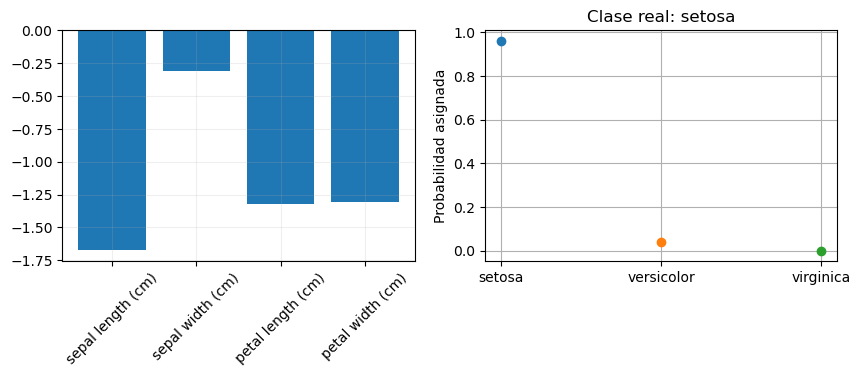

In [114]:
item = 0 # Modificar esta variable para evaluar otros ejemplos

ypred_real = model.predict(x_train[item][None, :])

plt.figure(figsize=(10, 3))
plt.subplot(1,2,1)
plt.bar(range(x_train.shape[1]), x_train[item])
plt.xticks(range(x_train.shape[1]), iris.feature_names, rotation=45)
plt.grid(alpha=0.2)
plt.subplot(1,2,2)
for c in range(3):
  plt.plot(c, ypred_real[0, c], 'o', label="Predicción "+str(iris.target_names[c]))
plt.xticks(range(3), iris.target_names)
plt.grid()
plt.title("Clase real: " + iris.target_names[t_train[item, 0]])
plt.ylabel("Probabilidad asignada")
plt.show()

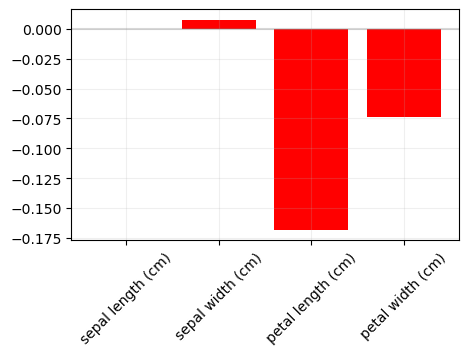

In [115]:
plt.figure(figsize=(5, 3))
plt.bar(range(x_train.shape[1]), R[item], color="red")
plt.xticks(range(x_train.shape[1]), iris.feature_names, rotation=45)
plt.grid(alpha=0.2)
plt.axhline(0.0, color="gray", alpha=0.3)
plt.show()

In [116]:
def dibuja_figura(item, x_train, x_train_modificado, ypred_real, ypred):
    plt.figure(figsize=(10, 3))
    plt.subplot(1,2,1)
    plt.bar(range(x_train.shape[1]), x_train[item], alpha=0.5)
    plt.bar(range(x_train.shape[1]), x_train_modificado, color="magenta", alpha=0.5)
    plt.xticks(range(x_train.shape[1]), iris.feature_names, rotation=45)
    plt.grid(alpha=0.2)
    plt.subplot(1,2,2)
    for c in range(3):
      plt.plot(c, ypred_real[0, c], 'o', label="Predicción real "+str(iris.target_names[c]))
      plt.plot(c, ypred[0, c], 'o', label="Predicción modificada "+str(iris.target_names[c]))
      plt.annotate('', xy=(c, ypred[0, c]), xytext=(c, ypred_real[0, c]), arrowprops=dict(arrowstyle='->', color="black"))
    plt.xticks(range(3), iris.target_names)
    plt.ylabel("Probabilidad asignada")
    plt.title("Clase real: " + iris.target_names[t_train[item, 0]])
    plt.grid()
    plt.show()

In [117]:
def explicabilidad(item, x_train, R, model):
    print(" >> La relevancia de los atributos es la siguiente:")
    plt.figure(figsize=(5, 3))
    plt.bar(range(x_train.shape[1]), R[item], color="red")
    plt.xticks(range(x_train.shape[1]), iris.feature_names, rotation=45)
    plt.grid(alpha=0.2)
    plt.axhline(0.0, color="gray", alpha=0.3)
    plt.show()

    if (R[item] > 0).any():
      print(" >> Si disminuyo un atributo con relevancia positiva -> la probabilidad de la clase real "+str(iris.target_names[t_train[item]])+" baja")
      x_train_modificado = x_train[item].copy()
      i_columna = np.random.choice(np.where(R[item] > 0)[0])
      x_train_modificado[i_columna] = x_train_modificado[i_columna] - 0.2
      ypred = model.predict(x_train_modificado[None, :], verbose=0)
      ypred_real = model.predict(x_train[item][None, :], verbose=0)
      dibuja_figura(item, x_train, x_train_modificado, ypred_real, ypred)

      print(" >> Si aumento un atributo con relevancia positiva -> la probabilidad de la clase real "+str(iris.target_names[t_train[item]])+" sube")
      x_train_modificado = x_train[item].copy()
      i_columna = np.random.choice(np.where(R[item] > 0)[0])
      x_train_modificado[i_columna] = x_train_modificado[i_columna] + 0.2
      ypred = model.predict(x_train_modificado[None, :], verbose=0)
      ypred_real = model.predict(x_train[item][None, :], verbose=0)
      dibuja_figura(item, x_train, x_train_modificado, ypred_real, ypred)

    if (R[item] < 0).any():
      print(" >> Si disminuyo un atributo con relevancia negativa -> la probabilidad de la clase real "+str(iris.target_names[t_train[item]])+" sube")
      x_train_modificado = x_train[item].copy()
      i_columna = np.random.choice(np.where(R[item] < 0)[0])
      x_train_modificado[i_columna] = x_train_modificado[i_columna] - 0.2
      ypred = model.predict(x_train_modificado[None, :], verbose=0)
      ypred_real = model.predict(x_train[item][None, :], verbose=0)
      dibuja_figura(item, x_train, x_train_modificado, ypred_real, ypred)

      print(" >> Si aumento un atributo con relevancia negativa -> la probabilidad de la clase real "+str(iris.target_names[t_train[item]])+" baja")
      x_train_modificado = x_train[item].copy()
      i_columna = np.random.choice(np.where(R[item] < 0)[0])
      x_train_modificado[i_columna] = x_train_modificado[i_columna] + 0.2
      ypred = model.predict(x_train_modificado[None, :], verbose=0)
      ypred_real = model.predict(x_train[item][None, :], verbose=0)
      dibuja_figura(item, x_train, x_train_modificado, ypred_real, ypred)

 >> La relevancia de los atributos es la siguiente:


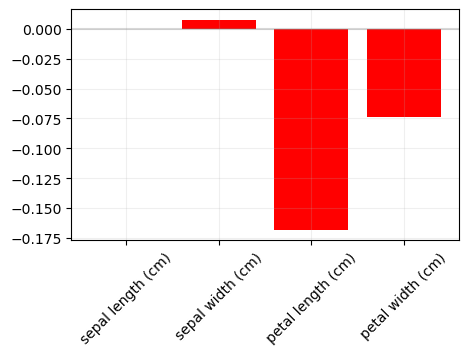

 >> Si disminuyo un atributo con relevancia positiva -> la probabilidad de la clase real ['setosa'] baja


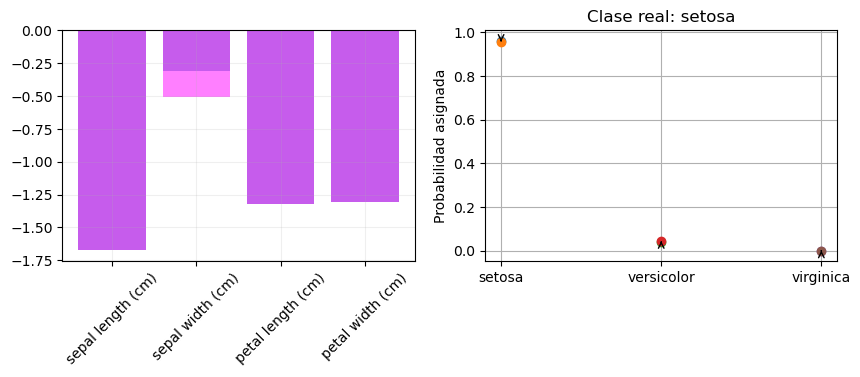

 >> Si aumento un atributo con relevancia positiva -> la probabilidad de la clase real ['setosa'] sube


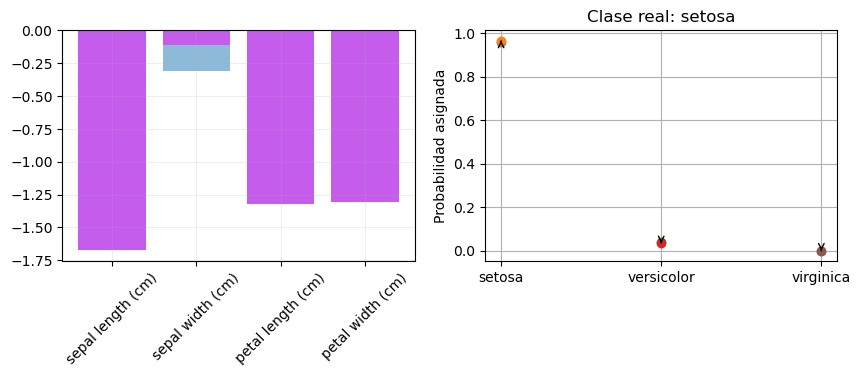

 >> Si disminuyo un atributo con relevancia negativa -> la probabilidad de la clase real ['setosa'] sube


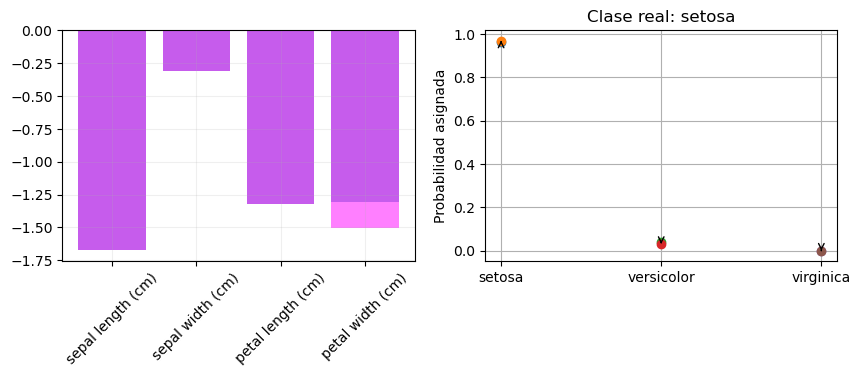

 >> Si aumento un atributo con relevancia negativa -> la probabilidad de la clase real ['setosa'] baja


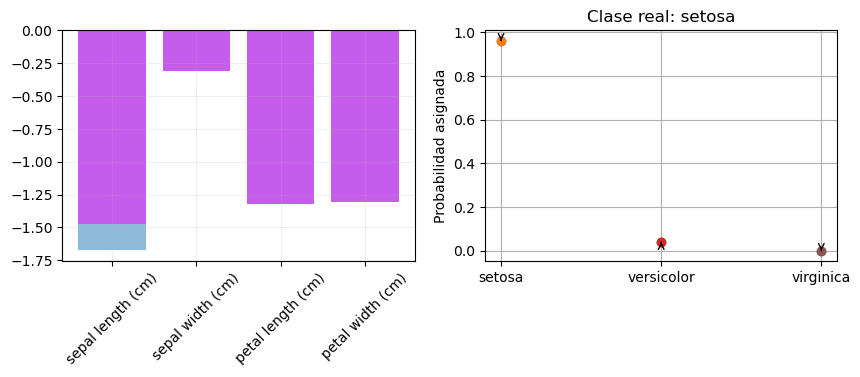

In [118]:
explicabilidad(item, x_train, R, model)

**Explicar la predicción de cada salida**

Podemos explicar el modelo para cada salida individualmente.

In [121]:
def dibuja_figura(item, x_train, x_train_modificado, ypred_real, ypred):
    plt.figure(figsize=(10, 3))
    plt.subplot(1,2,1)
    plt.bar(range(x_train.shape[1]), x_train[item], alpha=0.5)
    plt.bar(range(x_train.shape[1]), x_train_modificado, color="magenta", alpha=0.5)
    plt.xticks(range(x_train.shape[1]), iris.feature_names, rotation=45)
    plt.grid(alpha=0.2)
    plt.subplot(1,2,2)
    for c in range(3):
      plt.plot(c, ypred_real[0, c], 'o', label="Predicción real "+str(iris.target_names[c]))
      plt.plot(c, ypred[0, c], 'o', label="Predicción modificada "+str(iris.target_names[c]))
      plt.annotate('', xy=(c, ypred[0, c]), xytext=(c, ypred_real[0, c]), arrowprops=dict(arrowstyle='->', color="black"))
    plt.xticks(range(3), iris.target_names)
    plt.ylabel("Probabilidad asignada")
    plt.grid()
    plt.show()

In [159]:
def explicabilidad(item, x_train, R, model, class_to_analyze):
    print(" >> VAS A EXPLICAR LA CLASE <" + iris.target_names[class_to_analyze] + ">")
    print(" >> La relevancia de los atributos es la siguiente:")
    plt.figure(figsize=(5, 3))
    plt.bar(range(x_train.shape[1]), R[item], color="red")
    plt.xticks(range(x_train.shape[1]), iris.feature_names, rotation=45)
    plt.grid(alpha=0.2)
    plt.axhline(0.0, color="gray", alpha=0.3)
    plt.show()

    if (R[item].numpy() > 0).any():
      print(" >> Si disminuyo un atributo con relevancia positiva para la clase "+str(iris.target_names[class_to_analyze])+" -> la probabilidad de la clase predicha "+str(iris.target_names[class_to_analyze])+" baja")
      x_train_modificado = x_train[item].copy()
      i_columna = np.random.choice(np.where(R[item].numpy() > 0)[0])
      x_train_modificado[i_columna] = x_train_modificado[i_columna] - 0.2
      ypred = model.predict(x_train_modificado[None, :])
      ypred_real = model.predict(x_train[item][None, :])
      dibuja_figura(item, x_train, x_train_modificado, ypred_real, ypred)

      print(" >> Si aumento un atributo con relevancia positiva para la clase "+str(iris.target_names[class_to_analyze])+" -> la probabilidad de la clase predicha "+str(iris.target_names[class_to_analyze])+" sube")
      x_train_modificado = x_train[item].copy()
      i_columna = np.random.choice(np.where(R[item].numpy() > 0)[0])
      x_train_modificado[i_columna] = x_train_modificado[i_columna] + 0.2
      ypred = model.predict(x_train_modificado[None, :])
      ypred_real = model.predict(x_train[item][None, :])
      dibuja_figura(item, x_train, x_train_modificado, ypred_real, ypred)

    if (R[item].numpy() < 0).any():
      print(" >> Si disminuyo un atributo con relevancia negativa para la clase "+str(iris.target_names[class_to_analyze])+" -> la probabilidad de la clase predicha "+str(iris.target_names[class_to_analyze])+" sube")
      x_train_modificado = x_train[item].copy()
      i_columna = np.random.choice(np.where(R[item].numpy() < 0)[0])
      x_train_modificado[i_columna] = x_train_modificado[i_columna] - 0.2
      ypred = model.predict(x_train_modificado[None, :])
      ypred_real = model.predict(x_train[item][None, :])
      dibuja_figura(item, x_train, x_train_modificado, ypred_real, ypred)

      print(" >> Si aumento un atributo con relevancia negativa para la clase "+str(iris.target_names[class_to_analyze])+" -> la probabilidad de la clase predicha "+str(iris.target_names[class_to_analyze])+" baja")
      x_train_modificado = x_train[item].copy()
      i_columna = np.random.choice(np.where(R[item].numpy() < 0)[0])
      x_train_modificado[i_columna] = x_train_modificado[i_columna] + 0.2
      ypred = model.predict(x_train_modificado[None, :])
      ypred_real = model.predict(x_train[item][None, :])
      dibuja_figura(item, x_train, x_train_modificado, ypred_real, ypred)

1/1 [==============================] - 0s 14ms/step


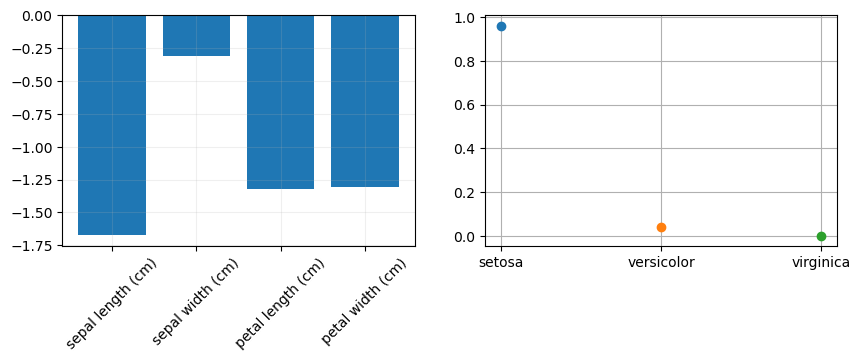

In [160]:
item = 0 # Modificar esta variable para evaluar otros ejemplos
class_to_explain = 0 # Modificar esta variable para evaluar cada clase

R = grad_x_input(x_train, model, t_train, explain_target=False, class_to_explain = 0)

ypred_real = model.predict(x_train[item][None, :])

plt.figure(figsize=(10, 3))
plt.subplot(1,2,1)
plt.bar(range(x_train.shape[1]), x_train[item])
plt.xticks(range(x_train.shape[1]), iris.feature_names, rotation=45)
plt.grid(alpha=0.2)
plt.subplot(1,2,2)
for c in range(3):
  plt.plot(c, ypred_real[0, c], 'o', label="Predicción "+str(iris.target_names[c]))
plt.xticks(range(3), iris.target_names)
plt.grid()
plt.show()

 >> VAS A EXPLICAR LA CLASE <setosa>
 >> La relevancia de los atributos es la siguiente:


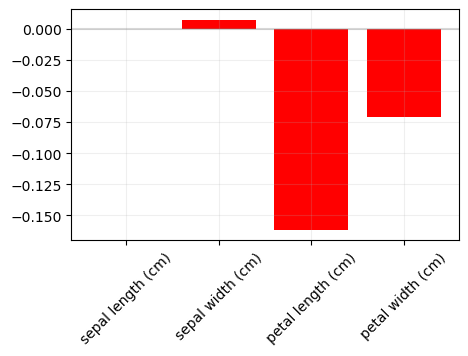

 >> Si disminuyo un atributo con relevancia positiva para la clase setosa -> la probabilidad de la clase predicha setosa baja
1/1 [==============================] - 0s 15ms/step


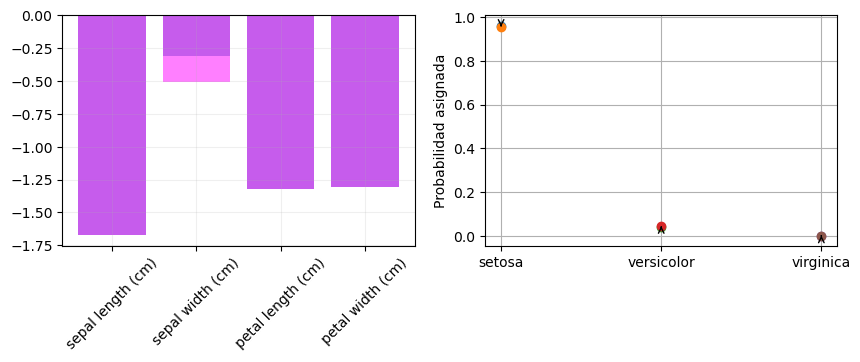

 >> Si aumento un atributo con relevancia positiva para la clase setosa -> la probabilidad de la clase predicha setosa sube
1/1 [==============================] - 0s 15ms/step


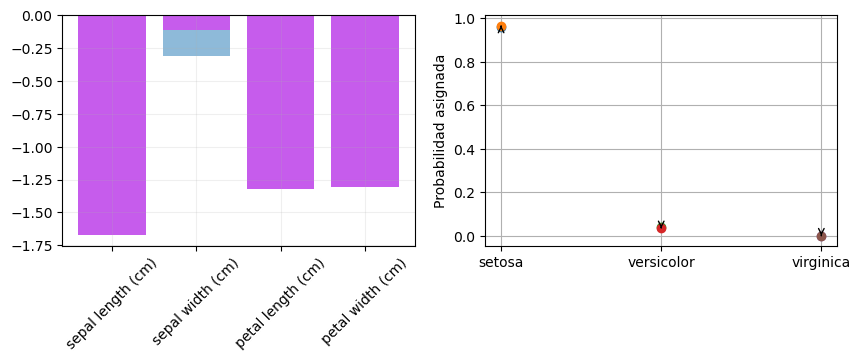

 >> Si disminuyo un atributo con relevancia negativa para la clase setosa -> la probabilidad de la clase predicha setosa sube
1/1 [==============================] - 0s 15ms/step


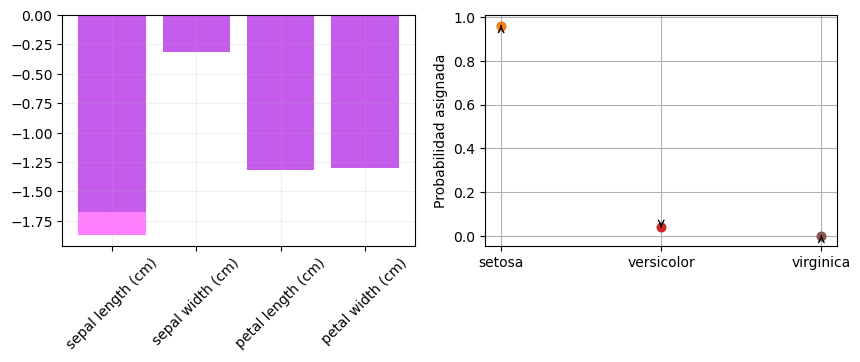

 >> Si aumento un atributo con relevancia negativa para la clase setosa -> la probabilidad de la clase predicha setosa baja
1/1 [==============================] - 0s 13ms/step


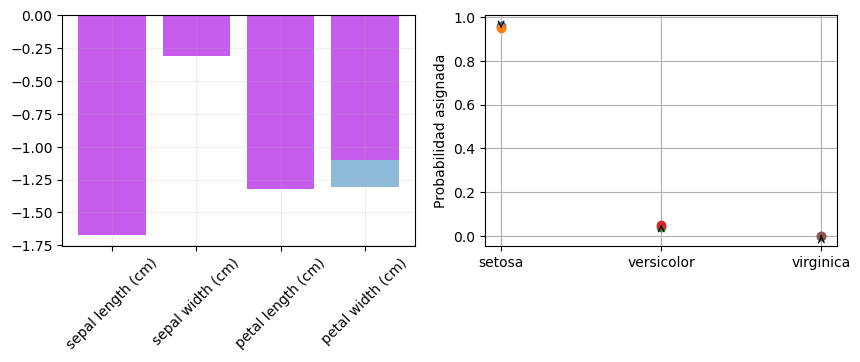

In [161]:
explicabilidad(item, x_train, R, model, class_to_explain)

**¿Y ahora qué?**